# MIT dataset

In [1]:
# import some common libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os

import matplotlib.pyplot as plt
from train import train_with_config, train
from evaluator import *
from model import *
from symnet.utils import dataset
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 
  
%load_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/mitstates/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


53753 activations loaded
#images = 34562


In [2]:
# train [img, attr_id, obj_id, pair_id, img_feature, img, attr_id, obj_id, pair_id, img_feature, aff_mask]
# test [img, attr_id, obj_id, pair_id, img_feature, aff_mask]

train_dataloader = dataset.get_dataloader('MITg', 'train', batchsize=64, with_image=True, shuffle=True, num_workers=4)
val_dataloader = dataset.get_dataloader('MITg', 'val', batchsize=64, with_image=True)
test_dataloader = dataset.get_dataloader('MITg', 'test', batchsize=64, with_image=True)

63440 activations loaded
natural split train
#images = 30338
63440 activations loaded
natural split val
#images = 10420
63440 activations loaded
natural split test
#images = 12995


In [ ]:
resnet_name = 'resnet101'
# compoResnet = CompoResnetFeatfile(resnet_name, 1).to(dev)
compoResnet = CompoResnet(resnet_name, 1).to(dev)

optimizer = torch.optim.AdamW(compoResnet.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
curr_epoch = 0
best_auc = 0

model_dir = './models/'
model_name = "resnet101"
model_path = '' if not model_name else os.path.join(model_dir, model_name+'.pt')

try:
  checkpoint = torch.load(model_path)
  compoResnet.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  if 'best_auc' in checkpoint:
    best_auc = checkpoint['best_auc']
  if 'epoch' in checkpoint:
    curr_epoch = checkpoint['epoch']
  print('Model loaded.')
except FileNotFoundError:
  pass
  
logger = SummaryWriter()

In [ ]:
num_epochs = 100
batch_size = 64
best_auc = train(compoResnet, optimizer, criterion, num_epochs, batch_size, train_dataloader, val_dataloader, logger,
      curr_epoch=curr_epoch, best_auc=best_auc, save_path=model_path)
curr_epoch += num_epochs
print('Best auc:', best_auc)

In [8]:
evaluator = Evaluator(test_dataloader, 20)
# fscore_evaluator = EvaluatorWithFscore(test_dataloader, 20, fscore_threshold=0.5, word2vec_path='./GoogleNews-vectors-negative300.bin', fscore_path='fscore.pt')

In [6]:
obj_scores = []
attr_scores = []
compoResnet.eval()
for i, batch in tqdm.tqdm(
    enumerate(test_dataloader),
    total=len(test_dataloader)):
  img, attr_id, obj_id = batch[:3]
#   _, attr_id, obj_id, _, img = batch[:5]
  if len(img) == 1:
    # Batchnorm doesn't accept batch with size 1
    continue
  obj_score, attr_score = compoResnet(img.to(dev))
  obj_scores.append(obj_score)
  attr_scores.append(attr_score)
obj_scores = torch.cat(obj_scores)
attr_scores = torch.cat(attr_scores)

100%|██████████| 204/204 [01:03<00:00,  3.22it/s]


In [9]:
summary = evaluator.eval_primitive_scores(attr_scores, obj_scores, topk=1)
for key, value in summary.items():
  print(f'{key}:{value:.4f}|', end='')

A:0.1936|O:0.3117|CwSeen:0.2450|CwUnseen:0.2304|CwHM:0.1462|CwAUC:0.0369|OpSeen:0.2450|OpUnseen:0.0831|OpHM:0.0829|OpAUC:0.0121|

In [114]:
results = []
for t in tqdm.tqdm(np.linspace(0.1, 0.5, 20), total=20):
  fscore_evaluator.update_threshold(t)
  results.append(fscore_evaluator.eval_primitive_scores(attr_scores, obj_scores))

100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


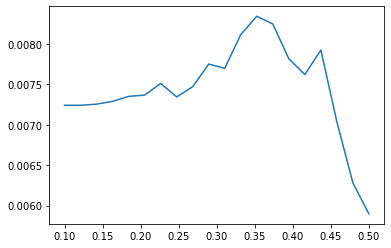

In [115]:
auc = [result['OpAUC'] for result in results]
plt.plot(np.linspace(0.1, 0.5, 20), auc)

In [116]:
summary = results[np.argmax(auc)]
for key, value in summary.items():
  print(f'{key}:{value:.4f}|', end='')

A:0.1715|O:0.2696|CwSeen:0.1853|CwUnseen:0.1933|CwHM:0.1106|CwAUC:0.0220|OpSeen:0.1853|OpUnseen:0.0795|OpHM:0.0678|OpAUC:0.0083|

In [ ]:
A:0.180|O:0.288|CwSeen:0.241|CwUnseen:0.222|CwHM:0.148|CwAUC:0.03786|OpSeen:0.241|OpUnseen:0.104|OpHM:0.099|OpAUC:0.01645|

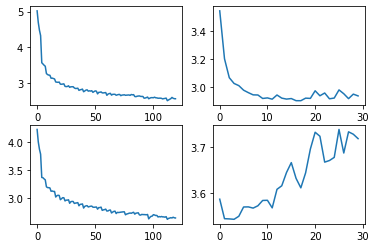

In [22]:
plt.subplot(2, 2, 1)
plt.plot(obj_loss_history[0])
plt.subplot(2, 2, 2)
plt.plot(obj_loss_history[1])
plt.subplot(2, 2, 3)
plt.plot(attr_loss_history[0])
plt.subplot(2, 2, 4)
plt.plot(attr_loss_history[1])

In [ ]:
config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "resnet": tune.choice(['resnet18', 'resnet50', 'resnet101']),
    "num_mlp_layers": tune.choice([1,2,4,6]),
}

In [ ]:
num_samples = 12
num_epochs = 6
scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=num_epochs,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
result = tune.run(
    partial(train_with_config, num_epochs=num_epochs),
    resources_per_trial={"cpu": 1, "gpu": 0.32},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

resnet = frozen(torch.hub.load('pytorch/vision:v0.9.0', best_trial.config["resnet"], pretrained=True))
best_mlp = partial(HalvingMLP, num_layers=best_trial.config["num_mlp_layers"])
best_trained_model = CompoResnet(resnet, obj_class, attr_class, best_mlp).to(dev)

best_checkpoint_dir = best_trial.checkpoint.value
model_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))['model_state_dict']
best_trained_model.load_state_dict(model_state)

test_acc = calc_acc(best_trained_model, test_dataloader)
print("\nBest trial test set accuracy: {}".format(test_acc))

Matches:

[0.30456985, 0.15528112, 0.02720025] : MLP2, 30 Epochs, Adam